# Recomendation book system

The goal of this notebook is to build a deeper intuition about recommendation systems by creating a web app that recommends movies. I'm using the Goodreads-books that's usings the 2020 (https://www.goodreads.com/api), The dataset consists on around 340556 books.

## Data exploration and analysis:

### Books
- bookID
     ```A unique Identification number for each book.```
    
- title
    ``` The name under which the book was published.```
    
- authors
    ```Names of the authors of the book. Multiple authors are delimited with -.```
    
- average_rating
    ```The average rating of the book received in total.```
    
- isbn
    ``` Another unique number to identify the book, the International Standard Book Number.```

- language_code
    ``` Helps understand what is the primary language of the book. For instance, eng is standard for English.```

- num_pages
    ```Number of pages the book contains.```

- ratings_count
    ``` Total number of ratings the book received.```

- text_reviews_countTotal 
    ``` number of written text reviews the book received.```



### Ratings:
- User-ID
    ``` Unique Identification number for each user```
    
- ISBN
    ```A unique Identification number for each book.```
- Book-Rating
    ```user rating of a book in particular```

First, I’ll use Pandas to get familiar with the data. I'll define three key libraries:

- **Pandas** for data manipulation and exploration
- **NumPy** for numerical operations and data handling
- **Matplotlib** for data visualization and plotting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [2]:
df = pd.read_csv('../data/Books/Ratings.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [4]:
df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [5]:
len(df.ISBN.unique()) 

340556

In [6]:
df["Book-Rating"].head()

0    0
1    5
2    0
3    3
4    6
Name: Book-Rating, dtype: int64

In [32]:
df.head()

,User-ID,ISBN,Book-Rating
0,104433,57188,0
1,104434,29750,5
2,104435,107392,0
3,104436,127253,3
4,104436,127287,6


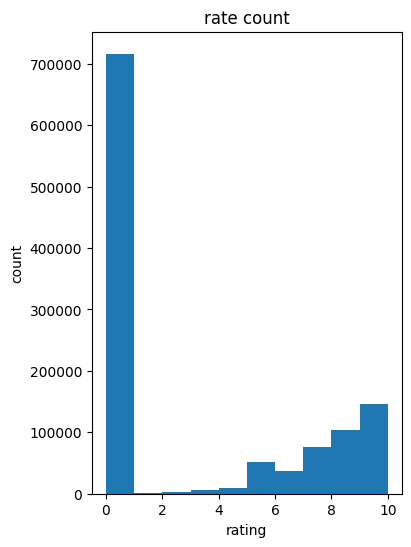

In [7]:
plt.figure(figsize=(4,6))
plt.hist(df["Book-Rating"])
plt.xlabel("rating")
plt.ylabel("count")
plt.title("rate count")
plt.show()

In [8]:
duplicates = df.duplicated()
print(f"number of duplicates {duplicates.sum()}")

number of duplicates 0


meaning we have no duplicated rows.

In [9]:
def plotCorrelationMatrix(df, graphWidth):
    filename = "ratings.csv"
        
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

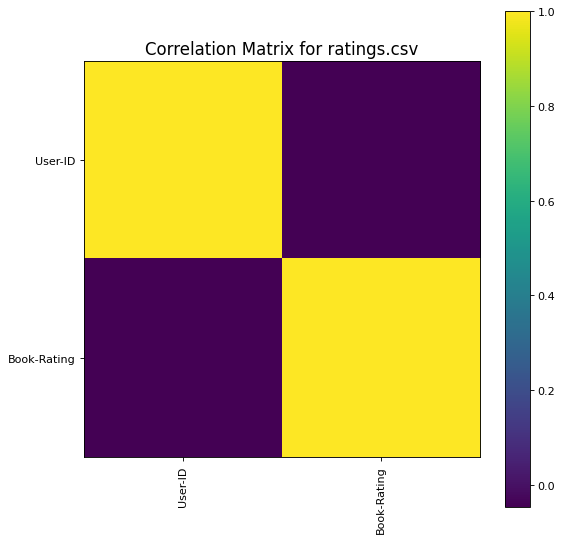

In [10]:
df_numeric = df.select_dtypes(include=['float', 'int'])
plotCorrelationMatrix(df_numeric,8)

Let's create a class to store all the data

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
import torch
from torch.utils.data import Dataset

class BookshelfDataset(Dataset):
    def __init__(self, users, books, ratings):
        """
        Initializes the parameters users, books, ratings.
        """
        # Reset indices to ensure integer indexing
        self.users = users.reset_index(drop=True)
        self.books = books.reset_index(drop=True)
        self.ratings = ratings.reset_index(drop=True)

    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.users)

    def __getitem__(self, item):
        """
        Retrieves a sample from the dataset at the specified index.
        """
        user = self.users[item]
        book = self.books[item]
        rating = self.ratings[item]

        return {
            "users": torch.tensor(user, dtype=torch.long),
            "books": torch.tensor(book, dtype=torch.long),
            "ratings": torch.tensor(rating, dtype=torch.float),
        }

    def get_item(self, item):
        """
        Retrieves raw user, book, and rating data without tensor conversion.
        """
        user = self.users[item]
        book = self.books[item]
        rating = self.ratings[item]

        return {
            "users": user,
            "books": book,
            "ratings": rating,
        }


In [13]:
df_prueba = BookshelfDataset(df["User-ID"],df["ISBN"],df["Book-Rating"])

item_2 = df_prueba.get_item(4)
item_2



{'users': 276729, 'books': '0521795028', 'ratings': 6}

### Vamos a crear el modelo, la idea es una red usando embeddings de user i book id.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
from sklearn import model_selection, preprocessing
import torch
import torch.nn as nn

In [16]:
import torch
import torch.nn as nn

class RecommenderBookSystem(nn.Module):
    def __init__(self,
                 num_users,
                 num_books,
                 embedding_size=256,
                 hidden_dim=256,
                 dropout_rate=0.2):
        super(RecommenderBookSystem, self).__init__()
        self.num_users = num_users
        self.num_books = num_books  # Cambié num_book a num_books para consistencia
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Crear las embeddings para usuarios y libros
        self.user_embedd = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.book_embedd = nn.Embedding(num_embeddings=self.num_books, embedding_dim=self.embedding_size)

        # Capas completamente conectadas
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)  # Capa de salida de 1 solo valor para predecir la puntuación

        # Dropout y activación
        self.dropout = nn.Dropout(p=dropout_rate)  # Corregido `droput` a `dropout`
        self.relu = nn.ReLU()

    def forward(self, users, books):
        user_embedding = self.user_embedd(users)
        book_embedding = self.book_embedd(books)

        # Combinar las embeddings de usuario y libro
        combined = torch.cat([user_embedding, book_embedding], dim=1)
        
        # Paso por las capas de la red
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)  # Aplicar dropout después de la activación
        output = self.fc2(x)  # Salida final para la predicción de la puntuación

        return output


### Lets prepare our data

In [17]:
le_user = preprocessing.LabelEncoder()
le_book = preprocessing.LabelEncoder()
df["User-ID"] = le_user.fit_transform(df["User-ID"].values)
df["ISBN"] = le_book.fit_transform(df["ISBN"].values)


df_train, df_val = model_selection.train_test_split(df,test_size=0.1,random_state=23,stratify=df["Book-Rating"].values)

df_val.head()

,User-ID,ISBN,Book-Rating
947209,86358,207139,8
673248,61734,296529,0
10347,95,256956,0
63804,4671,166653,8
8421,105111,234941,0


In [18]:
train_dataset = BookshelfDataset(users = df_train["User-ID"], 
                                 books = df_train["ISBN"],
                                 ratings=df_train["Book-Rating"])

valid_dataset = BookshelfDataset(users = df_val["User-ID"],  
                                 books = df_val["ISBN"],
                                 ratings=df_val["Book-Rating"])

### Create Data Loaders

In [19]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers = 0)

val_loader = DataLoader(valid_dataset,batch_size = BATCH_SIZE , shuffle=True,num_workers = 0)

## Model Creation

In [20]:
recomendation_model = RecommenderBookSystem(
    num_users = len(le_user.classes_),
    num_books= len(le_book.classes_),
    embedding_size= 64,
    hidden_dim= 128,
    dropout_rate=0.2
).to(device)

optimizer = torch.optim.AdamW(recomendation_model.parameters(),lr=1e-4)
loss_func = nn.MSELoss()


In [21]:
EPOCHS = 20


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)



In [22]:
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

for e in range(EPOCHS):
    step_count = 0
    for i, train_data in enumerate(train_loader):
        output = recomendation_model(train_data["users"].to(device),train_data["books"].to(device))

        output = output.squeeze()
        rating = (train_data["ratings"].to(torch.float32).to(device))

        loss = loss_func(output,rating)
        total_loss+=loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        step_count += len(train_data["users"])

   
    
    if (step_count % log_progress_step == 0 or i == len(train_loader)-1):
        log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
        )
        total_loss = 0                  
        

Training on 1034802 samples...


20/20 | Step: 1034802/1034802 | Avg Loss: 2943.185919690

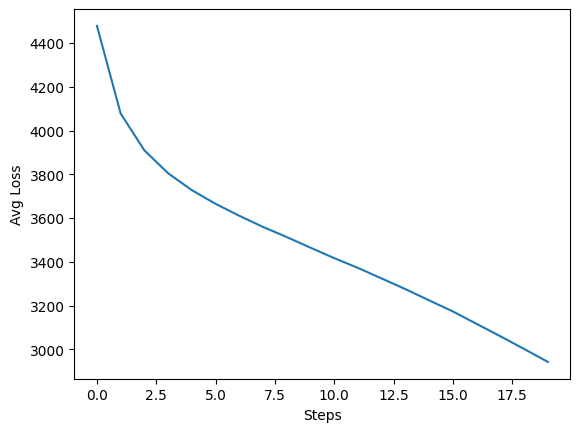

In [23]:
losses_cpu = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]

plt.figure()
plt.plot(losses_cpu)
plt.xlabel("Steps")
plt.ylabel("Avg Loss")
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recomendation_model.eval()

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recomendation_model(
            valid_data["users"].to(device), valid_data["books"].to(device)
        )
        ratings = valid_data["ratings"].to(device)
        y_pred.extend(output.cpu().numpy())
        y_true.extend(ratings.cpu().numpy())

# Calculate RMSE
rms = mean_squared_error(y_true, y_pred, squared=False)
print(f"RMSE: {rms:.4f}")

RMSE: 3.4816


In [25]:
from collections import defaultdict


def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum(
        (true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k]
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall


user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["books"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recomendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall

average_precision = sum(prec for prec in user_precisions.values()) / len(
    user_precisions
)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(
    user_based_recalls
)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")



precision @ 50: 0.6771
recall @ 50: 0.8172


In [30]:
df_books = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12508\1497428915.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv("../data/books/Books.csv")


In [31]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [69]:
def recommend_top_books(model, user_id, all_books, seen_books, device, k=5,batch_size =100):
    model.eval()
    unseen_books = [m for m in all_books if m not in seen_books]
    predictions = []

    with torch.no_grad():
        for i in range(0,len(unseen_books),batch_size):
            batch_unseen_books = unseen_books[i:i+batch_size]
            user_tensor = torch.tensor([user_id]*len(batch_unseen_books)).to(device)
            book_tensor = torch.tensor(batch_unseen_books).to(device)
            predicted_ratings = model(user_tensor,book_tensor).view(-1).tolist()
            predictions.extend(zip(batch_unseen_books,predicted_ratings))


    predictions.sort(key=lambda x:x[1],reverse = True)
    top_k_movies = [book_id for book_id, _ in predictions[:k]]
    return top_k_movies


all_books = pd.read_csv("../data/books/Books.csv", dtype={"Year-Of-Publication": str}, low_memory=False)


unique_books = df["ISBN"].unique().tolist()
user_id = 104434 #random
seen_books = set(df[df["User-ID"] == user_id]["ISBN"].tolist())

recomendations = recommend_top_books(recomendation_model, user_id, unique_books, seen_books, device)


print(recomendations)

[16200, 46838, 282735, 217995, 284499]


In [72]:
def show_recomend(recomend_indices, all_books_full):
    valid_recommendations = [idx for idx in recommendation_indices if idx < len(all_books_full)]

    recommended_books = all_books_full.iloc[valid_recommendations]
    
    print(recommended_books[["ISBN", "Book-Title"]])

all_books_full = pd.read_csv("../data/books/Books.csv", dtype={"Year-Of-Publication": str}, low_memory=False)

show_recomend(recomendations,all_books_full)

              ISBN                                         Book-Title
262129  0883186101  Physicists Desk Reference (Physicist's Desk Re...
180368  0918259053                                     No Hang Ups II
240234  0345403185                           If Wishes Were Horses...
47504   0312924208            School for Manners #06 Marrying Harriet


In [68]:
import torch

torch.save(recomendation_model.state_dict(), 'model.pth')

In [73]:
import pickle
import joblib  

filename = 'book_model.pkl'
joblib.dump(recomendation_model, filename)

['book_model.pkl']